In [1]:
#all necessary imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix
from scipy.spatial import cKDTree
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline


In [2]:
df = pd.read_csv(r"C:\Users\jaron\Documents\GenAI\Projekt\Ladesaeulenregister_BNetzA_smaller.CSV") 
display(df.head(3))
df.info()

,station_id,operator,name_map,status,equipment_type,n_ports,power_kw,commissioning_date,street,house_no,...,city,district,state,lat,lon,payment,opening_hours,commissioning_year,power_per_port,power_category
0,1010338,Albwerk Elektro- und Kommunikationstechnik GmbH,Albwerk Elektro- und Kommunikationstechnik GmbH,In Betrieb,Normalladeeinrichtung,2,22.0,11.01.2020,Ennabeurer Weg,0,...,Heroldstatt,Landkreis Alb-Donau-Kreis,Baden-Württemberg,48.442398,9.659075,NaN,Keine Angabe,2020,11.0,Low (≤22kW)
1,1063962,smopi® - Multi Chargepoint Solution GmbH,smopi,In Betrieb,Normalladeeinrichtung,4,22.0,23.11.2022,Albstraße,15,...,Heroldstatt,Landkreis Alb-Donau-Kreis,Baden-Württemberg,48.449424,9.672201,Onlinezahlungsverfahren;RFID-Karte,Keine Angabe,2022,5.5,Low (≤22kW)
2,1063963,smopi® - Multi Chargepoint Solution GmbH,smopi,In Betrieb,Normalladeeinrichtung,4,22.0,23.11.2022,Albstraße,15,...,Heroldstatt,Landkreis Alb-Donau-Kreis,Baden-Württemberg,48.449424,9.672201,Onlinezahlungsverfahren;RFID-Karte,Keine Angabe,2022,5.5,Low (≤22kW)


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 95565 entries, 0 to 95564
Data columns (total 21 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   station_id          95565 non-null  int64  
 1   operator            95565 non-null  object 
 2   name_map            41438 non-null  object 
 3   status              95565 non-null  object 
 4   equipment_type      95565 non-null  object 
 5   n_ports             95565 non-null  int64  
 6   power_kw            95565 non-null  float64
 7   commissioning_date  95565 non-null  object 
 8   street              95565 non-null  object 
 9   house_no            95565 non-null  object 
 10  zip                 95565 non-null  int64  
 11  city                95565 non-null  object 
 12  district            95565 non-null  object 
 13  state               95565 non-null  object 
 14  lat                 95565 non-null  float64
 15  lon                 95565 non-null  float64
 16  paym

In [3]:
print("="*70)
print("DATA CLEANING")
print("="*70)

df_clean = df.copy()
initial_count = len(df_clean)

# 1. Remove missing coordinates
df_clean = df_clean.dropna(subset=['lat', 'lon'])

# 2. Remove duplicates
df_clean = df_clean.drop_duplicates(subset='station_id', keep='first')

# 3. Keep only operational stations
df_clean = df_clean[df_clean['status'] == 'In Betrieb']

# 4. Fix power values
df_clean = df_clean[
    (df_clean['power_kw'] > 0) & 
    (df_clean['power_kw'] < 500) & 
    (df_clean['power_kw'].notna())
]

# 5. Fix ports
df_clean['n_ports'] = df_clean['n_ports'].fillna(1)
df_clean.loc[df_clean['n_ports'] == 0, 'n_ports'] = 1

# 6. Fix commissioning year
df_clean = df_clean[
    (df_clean['commissioning_year'] >= 2000) & 
    (df_clean['commissioning_year'] <= 2025) &
    (df_clean['commissioning_year'].notna())
]

# 7. Germany bounds only
lat_min, lat_max = 47.0, 55.5
lon_min, lon_max = 5.5, 15.5
df_clean = df_clean[
    (df_clean['lat'] >= lat_min) & (df_clean['lat'] <= lat_max) &
    (df_clean['lon'] >= lon_min) & (df_clean['lon'] <= lon_max)
]

# 8. Keep only essential columns for ML
columns_to_keep = ['station_id', 'lat', 'lon', 'power_kw', 'n_ports', 
                   'commissioning_year', 'city', 'state']
df_clean = df_clean[columns_to_keep]

print(f"\nOriginal: {initial_count:,}")
print(f"Cleaned: {len(df_clean):,}")
print(f"Removed: {initial_count - len(df_clean):,} ({(initial_count - len(df_clean))/initial_count*100:.1f}%)")
print(f"Columns kept: {len(df_clean.columns)}")
print("="*70)

display(df_clean.head())

DATA CLEANING

Original: 95,565
Cleaned: 95,499
Removed: 66 (0.1%)
Columns kept: 8


,station_id,lat,lon,power_kw,n_ports,commissioning_year,city,state
0,1010338,48.442398,9.659075,22.0,2,2020,Heroldstatt,Baden-Württemberg
1,1063962,48.449424,9.672201,22.0,4,2022,Heroldstatt,Baden-Württemberg
2,1063963,48.449424,9.672201,22.0,4,2022,Heroldstatt,Baden-Württemberg
3,1063964,48.449424,9.672201,22.0,2,2022,Heroldstatt,Baden-Württemberg
4,1010329,48.510500,9.609000,22.0,2,2019,Westerheim,Baden-Württemberg


In [4]:
# Creating geographic grid as an environment 

grid_size = 0.05  # ~5km cells
lats = np.arange(lat_min, lat_max, grid_size)
lons = np.arange(lon_min, lon_max, grid_size)

grid_cells = []
for lat in lats:
    for lon in lons:
        grid_cells.append({'lat': lat, 'lon': lon})

df_grid = pd.DataFrame(grid_cells)

# Label cells with stations (target variable)
tree = cKDTree(df_clean[['lat', 'lon']].values)
distances, _ = tree.query(df_grid[['lat', 'lon']].values, k=1)
df_grid['has_station'] = (distances < grid_size).astype(int)

print(f"Created {len(df_grid):,} grid cells")
print(f"Cells with stations: {df_grid['has_station'].sum():,}")
print(f"Empty cells: {(df_grid['has_station']==0).sum():,}")

Created 34,000 grid cells
Cells with stations: 15,103
Empty cells: 18,897


In [5]:
# this adds context for the model

# Distance to nearest station
distances, _ = tree.query(df_grid[['lat', 'lon']].values, k=1)
df_grid['dist_to_nearest_station'] = distances

# Stations within radius
distances_k, _ = tree.query(df_grid[['lat', 'lon']].values, k=100)
df_grid['stations_within_10km'] = (distances_k < 0.1).sum(axis=1)
df_grid['stations_within_20km'] = (distances_k < 0.2).sum(axis=1)
df_grid['stations_within_50km'] = (distances_k < 0.5).sum(axis=1)

# Density gradient
df_grid['density_gradient'] = df_grid['stations_within_10km'] - df_grid['stations_within_20km'] / 2

# Major cities
major_cities = [
    [52.52, 13.40], [48.13, 11.58], [50.11, 8.68], [53.55, 10.00],
    [51.23, 6.78], [48.78, 9.18], [50.94, 6.96], [51.34, 12.37],
    [52.27, 10.53], [49.01, 8.40]
]
city_tree = cKDTree(major_cities)
dist_to_city, _ = city_tree.query(df_grid[['lat', 'lon']].values)
df_grid['dist_to_major_city'] = dist_to_city
df_grid['near_major_city'] = (dist_to_city < 0.5).astype(int)

# Normalized coordinates
df_grid['lat_normalized'] = (df_grid['lat'] - lat_min) / (lat_max - lat_min)
df_grid['lon_normalized'] = (df_grid['lon'] - lon_min) / (lon_max - lon_min)


# New stations (added in last 2 years)
recent_stations = df_clean[df_clean['commissioning_year'] >= df_clean['commissioning_year'].max() - 2]
recent_tree = cKDTree(recent_stations[['lat', 'lon']].values)
recent_distances, _ = recent_tree.query(df_grid[['lat', 'lon']].values, k=20)
df_grid['recent_stations_nearby'] = (recent_distances < 0.2).sum(axis=1)

# Old stations (before 2020)
old_stations = df_clean[df_clean['commissioning_year'] < 2020]
if len(old_stations) > 0:
    old_tree = cKDTree(old_stations[['lat', 'lon']].values)
    old_distances, _ = old_tree.query(df_grid[['lat', 'lon']].values, k=20)
    df_grid['old_stations_nearby'] = (old_distances < 0.2).sum(axis=1)
else:
    df_grid['old_stations_nearby'] = 0

# Growth rate in area (recent vs old ratio)
df_grid['growth_ratio'] = df_grid['recent_stations_nearby'] / (df_grid['old_stations_nearby'] + 1)

# Year-over-year growth trend
# For each location it calculate how fast nearby stations are growing
growth_trends = []
for idx, row in df_grid.iterrows():
    nearby = np.sqrt((df_clean['lat'] - row['lat'])**2 + (df_clean['lon'] - row['lon'])**2) < 0.3
    if nearby.any():
        nearby_years = df_clean[nearby]['commissioning_year'].dropna()
        if len(nearby_years) > 1:
            # Simple trend: difference between latest and earliest year
            year_range = nearby_years.max() - nearby_years.min()
            if year_range > 0:
                growth_trends.append(len(nearby_years) / year_range)
            else:
                growth_trends.append(0)
        else:
            growth_trends.append(0)
    else:
        growth_trends.append(0)

df_grid['local_growth_trend'] = growth_trends

# Average power nearby
power_by_location = []
for idx, row in df_grid.iterrows():
    nearby = np.sqrt((df_clean['lat'] - row['lat'])**2 + (df_clean['lon'] - row['lon'])**2) < 0.2
    if nearby.any():
        power_by_location.append(df_clean[nearby]['power_kw'].mean())
    else:
        power_by_location.append(0)
df_grid['avg_power_nearby'] = power_by_location

print(f"Created {len(df_grid.columns) - 3} features (including temporal features)")

Created 14 features (including temporal features)


In [6]:
#feature list with temporal features
feature_cols = ['stations_within_10km', 'stations_within_20km', 'stations_within_50km',
                'density_gradient', 'dist_to_major_city', 'near_major_city', 
                'lat_normalized', 'lon_normalized', 
                'recent_stations_nearby', 'old_stations_nearby', 'growth_ratio', 
                'local_growth_trend', 'avg_power_nearby']

X = df_grid[feature_cols]
y = df_grid['has_station']


# Handle class imbalance
from sklearn.utils import resample
df_majority = df_grid[df_grid['has_station'] == 0]
df_minority = df_grid[df_grid['has_station'] == 1]
df_majority_downsampled = resample(df_majority, n_samples=len(df_minority)*3, random_state=42)
df_balanced = pd.concat([df_majority_downsampled, df_minority])

X_balanced = df_balanced[feature_cols]
y_balanced = df_balanced['has_station']

X_train, X_test, y_train, y_test = train_test_split(
    X_balanced, y_balanced, test_size=0.2, random_state=42, stratify=y_balanced
)

print(f"Training samples: {len(X_train):,}")
print(f"Test samples: {len(X_test):,}")
print(f"Features: {len(feature_cols)}")
print(f"Removed 'dist_to_nearest_station' to prevent data leakage")

Training samples: 48,329
Test samples: 12,083
Features: 13
Removed 'dist_to_nearest_station' to prevent data leakage


In [7]:
# Training models

models = {}

# Random Forest
rf_model = RandomForestClassifier(n_estimators=200, max_depth=15, random_state=42, n_jobs=-1, class_weight='balanced')
rf_model.fit(X_train, y_train)
models['Random Forest'] = rf_model
print("Random Forest trained")

# Gradient Boosting
gb_model = GradientBoostingClassifier(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42)
gb_model.fit(X_train, y_train)
models['Gradient Boosting'] = gb_model
print("Gradient Boosting trained")

# XGBoost
xgb_model = XGBClassifier(n_estimators=200, learning_rate=0.1, max_depth=5, random_state=42,
                          scale_pos_weight=(y_train==0).sum() / (y_train==1).sum())
xgb_model.fit(X_train, y_train)
models['XGBoost'] = xgb_model
print("XGBoost trained")

Random Forest trained
Gradient Boosting trained
XGBoost trained


In [8]:
print("\n" + "="*70)
print("MODEL EVALUATION")
print("="*70 + "\n")

results = []
for name, model in models.items():
    y_pred = model.predict(X_test)
    y_pred_proba = model.predict_proba(X_test)[:, 1]
    
    results.append({
        'Model': name,
        'Accuracy': accuracy_score(y_test, y_pred),
        'Precision': precision_score(y_test, y_pred),
        'Recall': recall_score(y_test, y_pred),
        'F1-Score': f1_score(y_test, y_pred),
        'ROC-AUC': roc_auc_score(y_test, y_pred_proba)
    })

results_df = pd.DataFrame(results).sort_values('ROC-AUC', ascending=False)
display(results_df)

best_model_name = results_df.iloc[0]['Model']
best_model = models[best_model_name]
print(f"\n Best Model: {best_model_name}")


MODEL EVALUATION



,Model,Accuracy,Precision,Recall,F1-Score,ROC-AUC
0,Random Forest,0.929902,0.813980,0.932804,0.869351,0.982557
1,Gradient Boosting,0.922784,0.841623,0.851374,0.846470,0.975836
2,XGBoost,0.898701,0.725132,0.957961,0.825442,0.973721



 Best Model: Random Forest


,Feature,Importance
0,stations_within_10km,0.267889
1,stations_within_20km,0.181149
8,recent_stations_nearby,0.124893
12,avg_power_nearby,0.096532
11,local_growth_trend,0.086163
9,old_stations_nearby,0.067732
10,growth_ratio,0.045993
3,density_gradient,0.038509
4,dist_to_major_city,0.027587
6,lat_normalized,0.024604


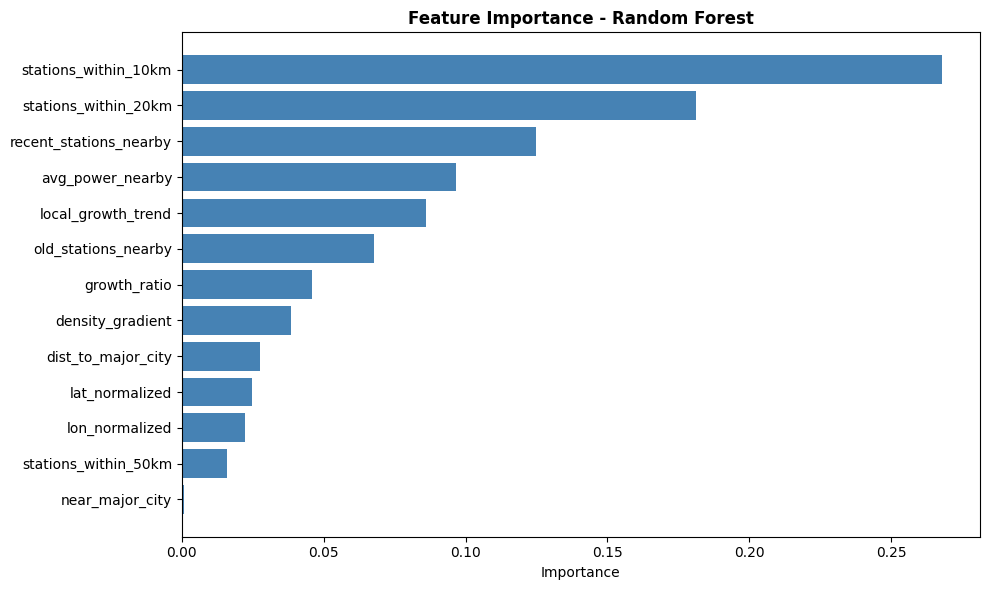

In [9]:
feature_importance = pd.DataFrame({
    'Feature': feature_cols,
    'Importance': best_model.feature_importances_
}).sort_values('Importance', ascending=False)

display(feature_importance)

plt.figure(figsize=(10, 6))
plt.barh(feature_importance['Feature'], feature_importance['Importance'], color='steelblue')
plt.xlabel('Importance')
plt.title(f'Feature Importance - {best_model_name}', fontweight='bold')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

In [10]:
df_grid['probability'] = best_model.predict_proba(df_grid[feature_cols])[:, 1]
df_predictions = df_grid[df_grid['has_station'] == 0].copy()

current_total = len(df_clean)
latest_year = df_clean['commissioning_year'].max()
recent_growth = df_clean[df_clean['commissioning_year'] >= latest_year - 3].groupby('commissioning_year').size().mean()
years_to_predict = 2026 - latest_year
new_stations_2026 = int(recent_growth * years_to_predict)

df_predictions_sorted = df_predictions.sort_values('probability', ascending=False)
top_predictions = df_predictions_sorted.head(new_stations_2026)

print(f"Current stations ({latest_year:.0f}): {current_total:,}")
print(f"Predicted new stations by 2026: {new_stations_2026:,}")
print(f"Total predicted 2026: {current_total + new_stations_2026:,}")
print(f"\nTop predictions probability range: {top_predictions['probability'].min():.3f} - {top_predictions['probability'].max():.3f}")

display(top_predictions[['lat', 'lon', 'probability', 'stations_within_20km', 'dist_to_major_city']].head(10))

Current stations (2025): 95,499
Predicted new stations by 2026: 16,665
Total predicted 2026: 112,164

Top predictions probability range: 0.000 - 0.996


,lat,lon,probability,stations_within_20km,dist_to_major_city
7732,48.90,12.10,0.996354,100,0.929139
27902,53.95,10.60,0.996236,100,0.721110
7521,48.85,11.55,0.989093,100,0.720625
9314,49.30,11.20,0.988148,100,1.230163
6941,48.70,12.55,0.980090,100,1.125078
4885,48.20,9.75,0.975786,100,0.813204
14738,50.65,12.40,0.970791,100,0.690652
6714,48.65,11.20,0.969524,100,0.644050
22031,52.50,7.05,0.967762,100,1.298384
14049,50.50,7.95,0.966875,100,0.827647


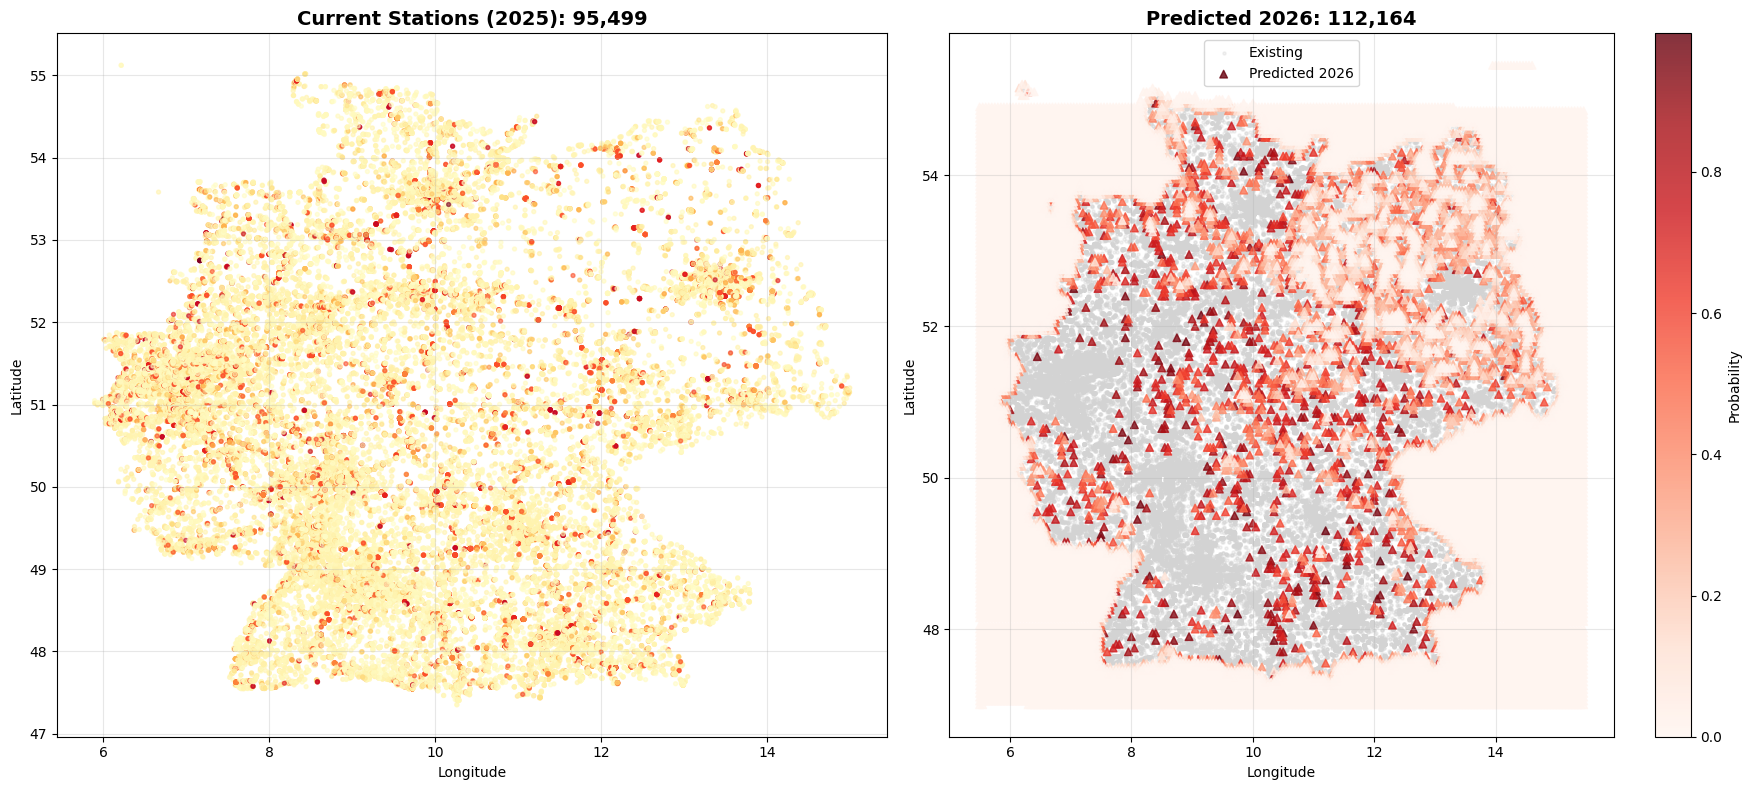

In [11]:
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Current stations
axes[0].scatter(df_clean['lon'], df_clean['lat'], c=df_clean['power_kw'], cmap='YlOrRd', s=8, alpha=0.6)
axes[0].set_title(f'Current Stations ({latest_year:.0f}): {current_total:,}', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Longitude')
axes[0].set_ylabel('Latitude')
axes[0].grid(True, alpha=0.3)

# Predictions
axes[1].scatter(df_clean['lon'], df_clean['lat'], c='lightgray', s=5, alpha=0.3, label='Existing')
scatter = axes[1].scatter(top_predictions['lon'], top_predictions['lat'], 
                          c=top_predictions['probability'], cmap='Reds', s=30, alpha=0.8, marker='^', label='Predicted 2026')
axes[1].set_title(f'Predicted 2026: {current_total + new_stations_2026:,}', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Longitude')
axes[1].set_ylabel('Latitude')
axes[1].legend()
axes[1].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[1], label='Probability')

plt.tight_layout()
plt.show()

In [12]:
# export new dataset
predictions_export = top_predictions[['lat', 'lon', 'probability']].copy()
predictions_export['predicted_year'] = 2026
predictions_export['model'] = best_model_name

predictions_export.to_csv('predicted_stations_2026.csv', index=False)